
**Before you dive into the implementations, I highly recommend first learning the heart of each algorithm—its core idea and how it works. You can explore this through YouTube tutorials, books, or online courses. This repository is meant to complement that knowledge by showing how to translate concepts into working code.**

# Isolation Forest for Anomaly Detection

Isolation Forest is an efficient and effective algorithm for anomaly detection based on the principle that anomalies are "few and different," making them easier to isolate. Unlike many other anomaly detection methods that try to profile normal data points, Isolation Forest explicitly isolates anomalies by randomly partitioning the data.

## Key Concepts:

*   **Isolation:** The process of separating an instance from the rest of the data.
*   **Isolation Trees (iTrees):** Isolation Forest uses an ensemble of iTrees to perform isolation. Each iTree is a binary tree structure.
*   **Random Partitioning:** Each iTree is built by recursively partitioning the data. At each node:
    *   A random feature is selected.
    *   A random split value within the range of that feature is chosen.
*   **Path Length:** The number of edges an instance traverses from the root of an iTree to a terminal node (leaf).
*   **Short Paths for Anomalies:** Because anomalies are "few and different," they tend to be isolated closer to the root of the iTree, resulting in shorter path lengths. Normal instances, being in denser regions, require more partitions and thus have longer path lengths.

## How Isolation Forest Works:

1.  **Build Isolation Trees:** Multiple iTrees are constructed. Each tree is built on a random subset of the data.
2.  **Random Feature and Split Selection:** For each node in an iTree, a random feature is chosen, and a random split value within the range of that feature is selected. This process is repeated recursively until each instance is isolated in a leaf node.
3.  **Calculate Path Lengths:** For each instance in the dataset, the path length is calculated for each iTree.
4.  **Anomaly Score (Scikit-learn Implementation):** The average path length over all iTrees is used to calculate an anomaly score for each instance. Scikit-learn modifies the original Isolation Forest score to produce scores in the approximate range of -1 to +1.

## Mathematical Formulation (Original Anomaly Score):

The *original* anomaly score $s$ of an instance $x$ (before scikit-learn's modifications) is defined as:

$$
s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
$$

Where:

*   $h(x)$ is the path length of instance $x$.
*   $E(h(x))$ is the average path length of $x$ over all iTrees.
*   $c(n)$ is the average path length of unsuccessful searches in a Binary Search Tree (BST) with $n$ instances. It is used to normalize the path lengths. It can be approximated as:

$$
c(n) = 2H(n - 1) - \frac{2(n - 1)}{n}
$$

Where $H(i)$ is the harmonic number.

## Interpreting the Anomaly Score (Scikit-learn's `decision_function()`):

Scikit-learn modifies the original anomaly score for consistency with other outlier detection methods. The `clf.decision_function(X)` method returns scores in the approximate range of -1 to +1:

*   **Scores close to -1:** Indicate anomalies (outliers).
*   **Scores close to +1:** Indicate normal instances (inliers).
*   **Scores around 0:** Indicate data points near the decision boundary.

The `clf.predict(X)` method uses a threshold of 0 on these scores to make binary predictions (-1 for outliers, +1 for inliers).

## Advantages of Isolation Forest:

*   **Efficient:** It has a linear time complexity with respect to the number of data points, making it suitable for large datasets.
*   **Effective for High-Dimensional Data:** It performs well in high-dimensional spaces.
*   **Handles Irrelevant Features:** The random feature selection makes it robust to irrelevant features.
*   **Low Memory Requirements:** It doesn't need to store all data points in memory.

## Disadvantages of Isolation Forest:

*   **Performance on Low Dimensional Datasets:** Can struggle on very low-dimensional datasets where it is more difficult to isolate anomalies with random splits.
*   **Parameter Tuning:** The number of trees (`n_estimators`) and the subsample size (`max_samples`) can affect performance and may need to be tuned. The contamination parameter is also important to set according to the expected proportion of outliers in the data.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [5]:
np.random.seed(42)
n_samples = 300
outliers_fraction = 0.05  # 5% outliers
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# Generate inliers (normal data)
data = 0.3 * np.random.randn(n_inliers, 2)
data = np.r_[data + 2, data - 2]  # Create two clusters
data = pd.DataFrame(data, columns=['Feature 1', 'Feature 2'])

# Generate outliers (anomalies)
outliers = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
outliers = pd.DataFrame(outliers, columns=['Feature 1', 'Feature 2'])



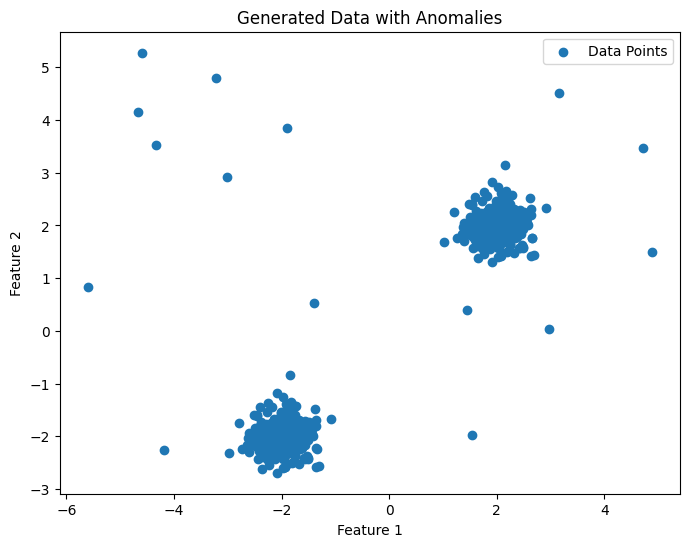

In [6]:
# Combine inliers and outliers
df = pd.concat([data, outliers], ignore_index=True)

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(df['Feature 1'], df['Feature 2'], label='Data Points')
plt.title('Generated Data with Anomalies')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [8]:
# 2. Scale the Data (Important for Isolation Forest)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=['Feature 1', 'Feature 2'])

In [9]:
# 3. Train the Isolation Forest Model
model = IsolationForest(contamination=outliers_fraction, random_state=42) #contamination is the expected proportion of outliers
model.fit(scaled_df)

IsolationForest(contamination=0.05, random_state=42)

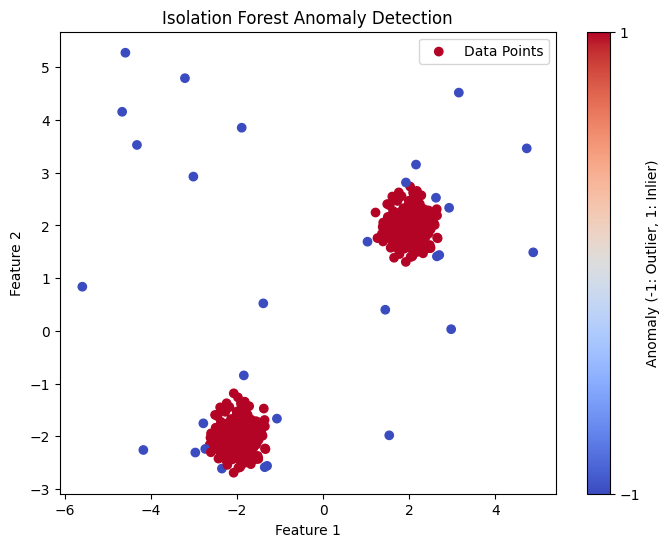

In [21]:
# 4. Predict Anomalies
predictions = model.predict(scaled_df)

# Convert predictions to -1 and 1 for easier interpretation (1: inlier, -1: outlier)
df['Anomaly'] = predictions


# Visualize Results (using a custom colormap for -1 and 1)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['Feature 1'], df['Feature 2'], c=df['Anomaly'], cmap='coolwarm', label='Data Points') #coolwarm for better visualization
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(scatter, ticks=[-1, 1], label='Anomaly (-1: Outlier, 1: Inlier)')
plt.legend()
plt.show()

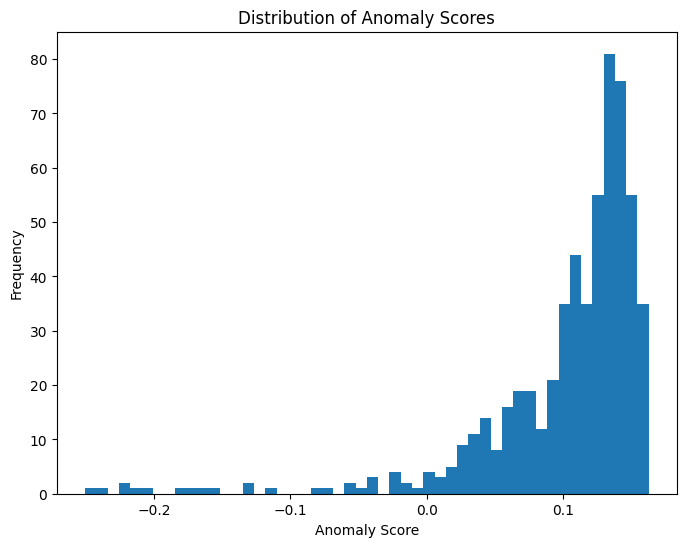

In [22]:
# 6. Anomaly Scores (Optional)
scores = model.decision_function(scaled_df) # lower scores indicate anomalies((-) scores)
df['Anomaly Score'] = scores

# Plot anomaly scores
plt.figure(figsize=(8, 6))
plt.hist(df['Anomaly Score'], bins=50)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

**Above the points are near to -1 are ouliers and near 0 are boundary points and near 1 are inliers. here we need to undersatnd that the original anomaly scores are in between 0 to 1 (before scaling), where high value(near 1) means are outliers and vice versa but isolationForest predict() function maps them to 1 to -1, where 1 is inliner and -1 is otliner for classification. Read below content for better insights-**

**Why this Conversion?**
The reason for this conversion is to make the IsolationForest scores consistent with other outlier/anomaly detection methods in scikit-learn, such as One-Class SVM. These methods often produce scores with a similar -1 to +1 range, making it easier to compare and use different algorithms within the same framework.

**How predict() Uses the Scores:**

* The predict() method then applies a threshold of 0 to these final scores to make predictions:

final_score < 0: Predict -1 (outlier)
final_score >= 0: Predict +1 (inlier)

**Example (Illustrative):**

* Let's say after averaging over all trees and calculating s(x, n), we get a score of 0.2 for a particular data point x.

* Invert: 1 - 0.2 = 0.8

* Offset (assuming contamination is not 'auto'): 0.8 - 0.5 = 0.3

* So, the final score returned by decision_function(x) would be 0.3. Since 0.3 >= 0, predict(x) would return +1 (inlier).

* If the original score was 0.9 (indicating a strong anomaly), the process would be:

* Invert: 1 - 0.9 = 0.1

* Offset: 0.1 - 0.5 = -0.4

* The final score would be -0.4. Since -0.4 < 0, predict(x) would return -1 (outlier).

**In summary:**

Scikit-learn modifies the original Isolation Forest score (0 to 1) by inverting it and applying an offset to obtain scores in the approximate range of -1 to +1. This is done for consistency with other outlier detection methods. The predict() method then uses a threshold of 0 on these modified scores for classification. While the exact formula for the offset when contamination = 'auto' is somewhat involved, this explanation provides the core idea of how the conversion works.

In [16]:
# Print some statistics
print(df['Anomaly'].value_counts())
print(df.head())

Anomaly
0    555
1     30
Name: count, dtype: int64
   Feature 1  Feature 2  Anomaly Score  Anomaly
0   2.149014   1.958521       0.152170        0
1   2.194307   2.456909       0.090957        0
2   1.929754   1.929759       0.162995        0
3   2.473764   2.230230       0.090462        0
4   1.859158   2.162768       0.151171        0


In [17]:
# Example to get indices of outliers
outlier_indices = df[df['Anomaly'] == 1].index
print("Indices of outliers:", outlier_indices)

Indices of outliers: Index([ 89, 104, 110, 131, 142, 210, 239, 322, 389, 395, 416, 427, 500, 524,
       557, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582,
       583, 584],
      dtype='int64')
